# How to use polygons or lines as exposure

Exposure in CLIMADA are usually represented as individual points or a raster of points.
See [Exposures](climada_entity_Exposures.ipynb) tutorial to learn how to fill and use exposures.
In this tutorial we show you how to run the impact calculation chain if you have polygons or lines to start with.
The approach provides an all-in-one method for impact calculation: `calc_geom_impact`
It features three sub-steps, for which the current util module `lines_polys_handler` also provides separate functions:
1. Disaggregation of line and polygon data into point exposure:
    * Interpolate geometries to points to fit in an `Exposure` instance; 
    * Disaggregate the respective geometry values to the point values
2. Perform the impact calculation in CLIMADA with the point exposure
3. Aggregate the calculated point `Impact` back to an impact instance for the initial polygons or lines  

### How is this tutorial structured?

* **[Part 1](#Part1): Polygons (Data: Provinces in the Netherlands)**
     * [Part 1.1](#Part1.1) : Loading Data
     * [Part 1.2](#Part1.2) : Calculating Polygon Impacts - all in one 
     * [Part 1.3](#Part1.3) : Calculating Polygon Impacts - step by step
* **[Part 2](#Part2): Lines (Data: Railways in the Netherlands)**
     * [Part 2.1](#Part2.1) : Loading Data
     * [Part 2.2](#Part2.2) : Calculating Line Impacts - all in one 
     * [Part 2.3](#Part2.3) : Calculating Line Impacts - step by step

## <a id='Part1'></a> Part 1: Polygons
Polygons or shapes are a common geographical representation of countries, states etc. as for example in NaturalEarth.
Map data, as for example buildings, etc. obtained from openstreetmap (see tutorial [here](https://github.com/CLIMADA-project/climada_petals/blob/feature/osm_loaders/doc/tutorial/climada_exposures_openstreetmap.ipynb)), also frequently come as (multi-)polygons.
Here we want to show you how to deal with exposure information as polygons.

### <a id='Part1.1'></a> 1.1 Load data

Lets assume we have the following data given. The polygons of the admin-1 regions of the Netherlands and an exposure value each, which we gather in a geodataframe. We want to know the Impact of Lothar on each admin-1 region.

In this tutorial, we shall see how to compute impacts for exposures defined on shapely geometries (polygons and/or lines). The basic principle is to disaggregate the geometries to a raster of points, compute the impact per points, and then re-aggregate. To do so, several methods are available. Here is a brief overview.

In [1]:
# Imports
import geopandas as gpd
import pandas as pd
from pathlib import Path

from climada.entity import Exposures
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs import ImpactFuncSet
from climada.engine import Impact
from climada.hazard.storm_europe import StormEurope
import climada.util.lines_polys_handler as u_lp_handler
from climada.util.constants import DEMO_DIR, WS_DEMO_NC

In [2]:
def gdf_poly():
    from cartopy.io import shapereader
    from climada_petals.entity.exposures.black_marble import country_iso_geom

    # open the file containing the Netherlands admin-1 polygons
    shp_file = shapereader.natural_earth(resolution='10m',
                                            category='cultural',
                                            name='admin_0_countries')
    shp_file = shapereader.Reader(shp_file)

    # extract the NL polygons
    prov_names = {'Netherlands': ['Groningen', 'Drenthe',
                                  'Overijssel', 'Gelderland',
                                                    'Limburg', 'Zeeland',
                                                    'Noord-Brabant', 'Zuid-Holland',
                                                    'Noord-Holland', 'Friesland',
                                                    'Flevoland', 'Utrecht']
                                   }
    polygon_Netherlands, polygons_prov_NL = country_iso_geom(prov_names,
                                   shp_file)

    # assign a value to each admin-1 area (assumption 100'000 USD per inhabitant)
    population_prov_NL = {'Drenthe':493449, 'Flevoland':422202,
                     'Friesland':649988, 'Gelderland':2084478,
                     'Groningen':585881, 'Limburg':1118223,
                     'Noord-Brabant':2562566, 'Noord-Holland':2877909,
                     'Overijssel':1162215, 'Zuid-Holland':3705625,
                     'Utrecht':1353596, 'Zeeland':383689}
    value_prov_NL = {n: 100000 * population_prov_NL[n] for n in population_prov_NL.keys()}

    # combine into GeoDataFrame and add a coordinate reference system to it:
    df1 = pd.concat([pd.DataFrame.from_dict(population_prov_NL, orient='index', columns=['population']), pd.DataFrame.from_dict(value_prov_NL, orient='index', columns=['value'])], axis=1)
    df1['geometry'] = [poly for poly in polygons_prov_NL.values()][0]
    gdf_polys = gpd.GeoDataFrame(df1)
    gdf_polys = gdf_polys.set_crs(epsg=4326)
    return gdf_polys

In [3]:
exp_nl_poly = Exposures(gdf_poly())
exp_nl_poly.gdf['impf_WS'] = 1
exp_nl_poly.gdf.head()

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


,population,value,geometry,impf_WS
Drenthe,493449,49344900000,"MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...",1
Flevoland,422202,42220200000,"POLYGON ((7.07215 52.84132, 7.06198 52.82401, ...",1
Friesland,649988,64998800000,"POLYGON ((6.71908 52.62676, 6.70179 52.61911, ...",1
Gelderland,2084478,208447800000,"POLYGON ((6.77158 52.10879, 6.76587 52.10840, ...",1
Groningen,585881,58588100000,"POLYGON ((5.94606 51.74629, 5.94013 51.74263, ...",1


<AxesSubplot:>

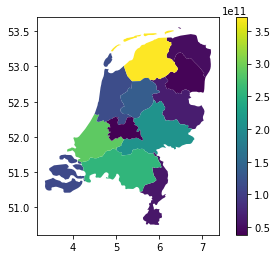

In [4]:
# take a look
exp_nl_poly.gdf.plot('value', legend=True)

In [5]:
# define hazard
storms = StormEurope.from_footprints(WS_DEMO_NC, description='test_description')
# define impact function
impf = ImpfStormEurope.from_welker()
impf_set = ImpactFuncSet()
impf_set.append(impf)

2022-02-24 18:34:47,119 - climada.hazard.storm_europe - INFO - Constructing centroids from /Users/evelynm/climada/demo/data/fp_lothar_crop-test.nc
2022-02-24 18:34:47,190 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/evelynm/climada_python/climada/hazard/centroids/centr.py:822: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


2022-02-24 18:34:48,103 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.


### 1.2  <a id='Part1.2'></a> Compute polygon impacts - all in one

**All in one:** The main method `calc_geom_impact` provides a two disaggregation kwargs, specifiying the target resolution (`res`) and the method on how to distribute the value column among the newly generated points (`disagg`). 

**Example 1**: Target resolution in degrees lat/lon, equal (average) distribution of values among points.

In [6]:
imp_deg = u_lp_handler.calc_geom_impact(
    exp=exp_nl_poly, impf_set=impf_set, haz=storms,
    res=0.005, disagg='avg')

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2022-02-24 18:35:13,084 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-02-24 18:35:13,156 - climada.entity.exposures.base - INFO - Matching 195323 exposures with 9944 centroids.
2022-02-24 18:35:13,158 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-02-24 18:35:13,340 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-02-24 18:35:13,343 - climada.engine.impact - INFO - Calculating damage for 195323 assets (>0) and 2 events.


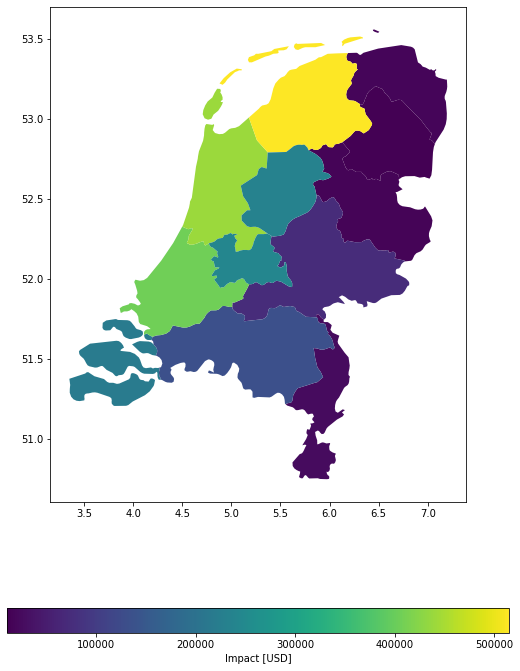

In [7]:
u_lp_handler.plot_eai_exp_geom(imp_deg);

**Example 2**: Specify target resolution in a desired metre-distance (kwarg `to_meters`)

In [8]:
imp_m = u_lp_handler.calc_geom_impact(
    exp=exp_nl_poly, impf_set=impf_set, haz=storms,
    res=500, to_meters=True, disagg='avg')

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2022-02-24 18:35:17,506 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-02-24 18:35:17,563 - climada.entity.exposures.base - INFO - Matching 148369 exposures with 9944 centroids.
2022-02-24 18:35:17,565 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-02-24 18:35:17,709 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-02-24 18:35:17,712 - climada.engine.impact - INFO - Calculating damage for 148369 assets (>0) and 2 events.


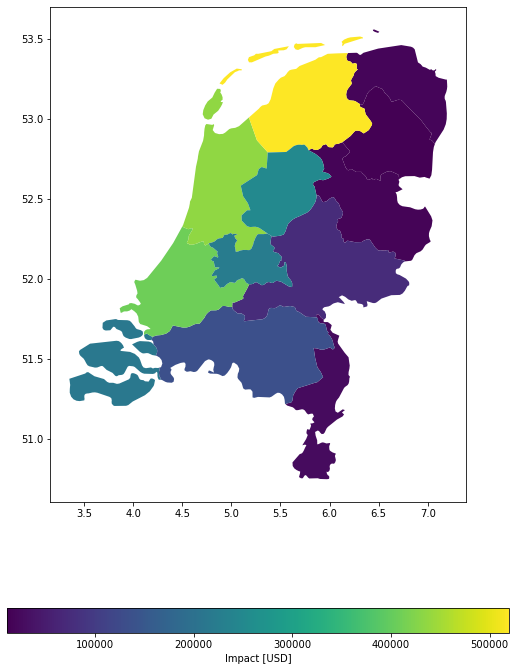

In [9]:
u_lp_handler.plot_eai_exp_geom(imp_m);

For this specific case, both disaggregation methods provide a relatively similar result, given the chosen numbers:

In [10]:
(imp_deg.eai_exp - imp_m.eai_exp) / imp_deg.eai_exp

array([ 0.0038771 ,  0.00614586, -0.00107029,  0.00140608, -0.0066888 ,
        0.01275482, -0.00171755, -0.00453276,  0.00741871, -0.00937002,
       -0.06937751,  0.08050376])

### 1.3 <a id='Part1.3'></a>  Compute polygon impacts - step by step

**Step 1:** Disaggregate polygon exposures to points. It is useful to do this separately, when the discretized exposure is used several times, for example, to compute with different hazards.

Several disaggregation methods can be used as shown below:

In [11]:
# Disaggregate exposure to 10'000 metre grid, each point gets average value within polygon.
exp_pnt = u_lp_handler.exp_geom_to_pnt(exp_nl_poly, res=10000, to_meters=True, disagg='avg')
exp_pnt.gdf.head()

2022-02-24 18:35:43,143 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

population         value  \
Drenthe 0      493449  1.897881e+09   
        1      493449  1.897881e+09   
        2      493449  1.897881e+09   
        3      493449  1.897881e+09   
        4      493449  1.897881e+09   

                                               geometry_orig  impf_WS  \
Drenthe 0  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        1  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        2  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        3  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        4  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   

                           geometry   latitude  longitude  
Drenthe 0  POINT (6.97754 52.99002)  52.990022   6.977544  
        1  POINT (7.06738 52.99002)  52.990022   7.067376  
        2  POINT (7.15721 52.99002)  52.990022   7.157207  
        3  POINT (6.25889 53.13924)  53.139237   6.258892  
        4  POINT (6.34872 53.13924)  53.139237   6.348724

In [12]:
# Disaggregate exposure to 0.1° grid, no value disaggregation specified --> replicate initial value
exp_pnt2 = u_lp_handler.exp_geom_to_pnt(exp_nl_poly, res=0.1, to_meters=False, disagg=None)
exp_pnt2.gdf.head()

2022-02-24 18:35:48,215 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

population        value  \
Drenthe 0      493449  49344900000   
        1      493449  49344900000   
        2      493449  49344900000   
        3      493449  49344900000   
        4      493449  49344900000   

                                               geometry_orig  impf_WS  \
Drenthe 0  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        1  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        2  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        3  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        4  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   

                           geometry   latitude  longitude  
Drenthe 0  POINT (7.06906 52.94132)  52.941317    7.06906  
        1  POINT (6.86906 53.04132)  53.041317    6.86906  
        2  POINT (6.96906 53.04132)  53.041317    6.96906  
        3  POINT (7.06906 53.04132)  53.041317    7.06906  
        4  POINT (7.16906 53.04132)  53.041317    7.16906

In [13]:
# Disaggregate exposure to 1'000 metre grid, each point gets value corresponding to its representative area.
exp_pnt3 = u_lp_handler.exp_geom_to_pnt(exp_nl_poly, res=1000, to_meters=True, disagg='surf')
exp_pnt3.gdf.head()

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2022-02-24 18:35:50,008 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:478: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_points = gdf_points.explode()


population    value  \
Drenthe 0      493449  1000000   
        1      493449  1000000   
        2      493449  1000000   
        3      493449  1000000   
        4      493449  1000000   

                                               geometry_orig  impf_WS  \
Drenthe 0  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        1  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        2  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        3  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   
        4  MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...        1   

                           geometry   latitude  longitude  
Drenthe 0  POINT (7.05839 52.85616)  52.856164   7.058393  
        1  POINT (7.06738 52.85616)  52.856164   7.067376  
        2  POINT (7.07636 52.85616)  52.856164   7.076359  
        3  POINT (7.02246 52.87102)  52.871017   7.022460  
        4  POINT (7.03144 52.87102)  52.871017   7.031443

**Step 2:** Calculate point impacts & re-aggregate them afterwards

In [14]:
# Point-impact
imp_pnt = Impact()
imp_pnt.calc(exp_pnt3, impf_set, hazard=storms, save_mat=True)

# Aggregated impact
imp_geom = u_lp_handler.impact_pnt_agg(imp_pnt, exp_pnt3, agg='sum')

2022-02-24 18:36:05,307 - climada.entity.exposures.base - INFO - Matching 37082 exposures with 9944 centroids.
2022-02-24 18:36:05,311 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-02-24 18:36:05,363 - climada.engine.impact - INFO - Calculating damage for 37082 assets (>0) and 2 events.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<AxesSubplot:>

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


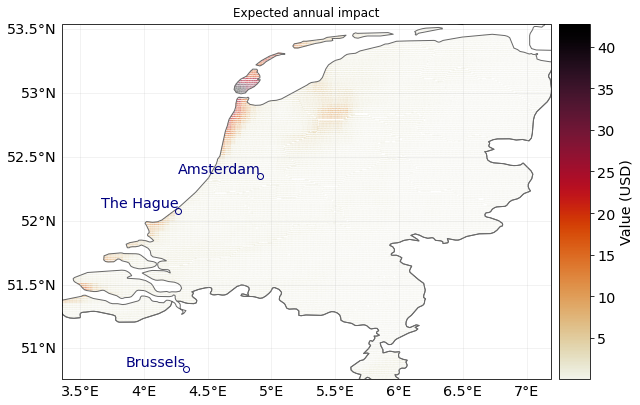

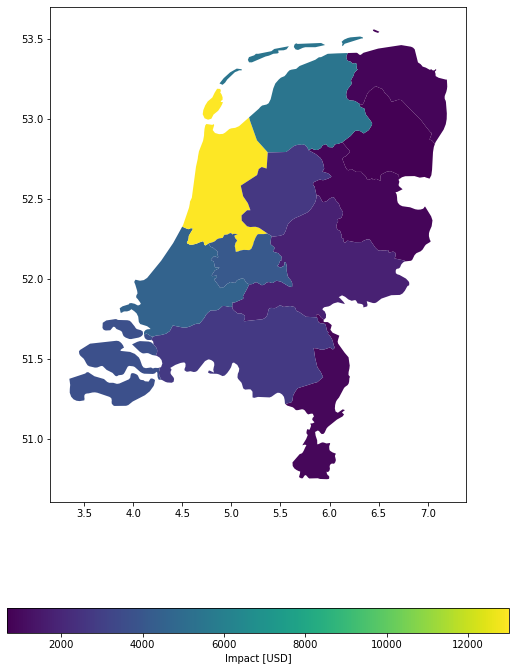

In [15]:
# Plot point-impacts and aggregated impacts
imp_pnt.plot_hexbin_eai_exposure()
u_lp_handler.plot_eai_exp_geom(imp_geom)

**Aggregated impact, in detail**

In [16]:
# aggregate impact
mat_agg = u_lp_handler.aggregate_impact_mat(imp_pnt, exp_pnt3.gdf, agg='sum')

eai_exp = u_lp_handler.eai_exp_from_mat(imp_mat=mat_agg, freq=imp_pnt.frequency)
at_event = u_lp_handler.at_event_from_mat(imp_mat=mat_agg)
aai_agg = u_lp_handler.aai_agg_from_at_event(at_event=at_event, freq=imp_pnt.frequency)

In [17]:
eai_exp

array([  856.11850799,   675.34518661,   836.21724333,  1801.41563099,
         898.61365338,  3682.65817914,  2744.64638706,  4546.8037723 ,
       13014.52990308,  5486.16019796,  2684.91758723,  4055.85977959])

In [18]:
at_event

array([432121.10340021,  21995.04291506])

In [19]:
aai_agg

41283.28602866131

## <a id='Part2'></a> Part 2: Lines
Lines are common geographical representation of transport infrastructure like streets, train tracks or powerlines etc. Here we will play it through for the case of winter storm Lothar's impact on the Dutch Railway System:

### <a id='Part2.1'></a> 2.1: Loading Data

Note: Hazard and impact functions data have been loaded above.

In [20]:
def gdf_lines():
    gdf_lines = gpd.read_file(Path(DEMO_DIR,'nl_rails.gpkg'))
    gdf_lines = gdf_lines.to_crs(epsg=4326)
    return gdf_lines

In [21]:
exp_nl_lines = Exposures(gdf_lines())
exp_nl_lines.gdf['impf_WS'] = 1
exp_nl_lines.gdf['value'] = 1
exp_nl_lines.gdf.head()

,distance,geometry,impf_WS,value
0,9414.978692,"LINESTRING (6.08850 50.87940, 6.08960 50.87850...",1,1
1,10397.965112,"LINESTRING (6.17673 51.35530, 6.17577 51.35410...",1,1
2,26350.219724,"LINESTRING (5.68096 51.25040, 5.68422 51.25020...",1,1
3,40665.249638,"LINESTRING (5.68096 51.25040, 5.67711 51.25030...",1,1
4,8297.689753,"LINESTRING (5.70374 50.85490, 5.70531 50.84990...",1,1


<AxesSubplot:>

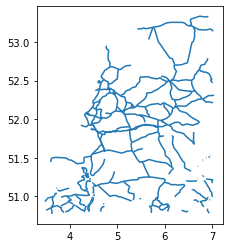

In [22]:
exp_nl_lines.gdf.plot()

### <a id='Part2.2'></a> 2.2: Calculating line impacts - all in one

In [23]:
imp_deg = u_lp_handler.calc_geom_impact(
    exp=exp_nl_lines, impf_set=impf_set, haz=storms,
    res=0.005, disagg='avg')

/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:653: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  line_lengths = gdf_lines.length
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2022-02-24 18:40:10,434 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-02-24 18:40:10,440 - climada.entity.exposures.base - INFO - Matching 10175 exposures with 9944 centroids.
2022-02-24 18:40:10,441 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-02-24 18:40:10,460 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-02-24 18:40:10,463 - climada.engine.impact - INFO - Calculating damage for 10175 assets (>0) and 2 events.


/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:671: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_points = gdf_points.explode()


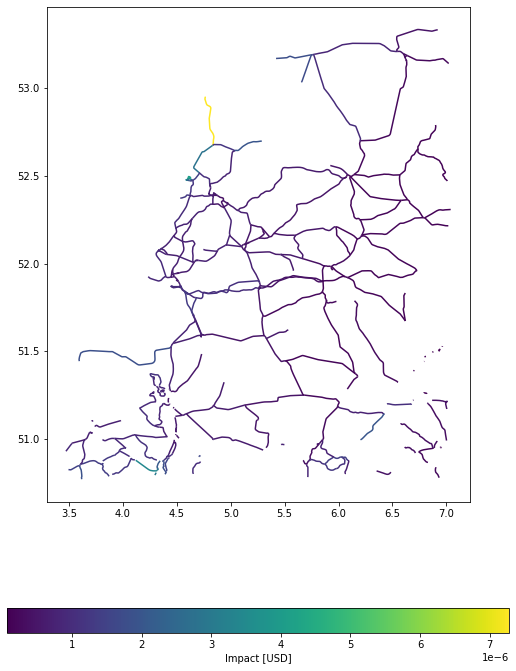

In [24]:
u_lp_handler.plot_eai_exp_geom(imp_deg);

In [25]:
imp_m = u_lp_handler.calc_geom_impact(
    exp=exp_nl_lines, impf_set=impf_set, haz=storms,
    res=500, to_meters=True, disagg='avg')

2022-02-24 18:40:36,620 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-02-24 18:40:36,626 - climada.entity.exposures.base - INFO - Matching 8399 exposures with 9944 centroids.
2022-02-24 18:40:36,628 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-02-24 18:40:36,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_WS
2022-02-24 18:40:36,649 - climada.engine.impact - INFO - Calculating damage for 8399 assets (>0) and 2 events.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:671: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_points = gdf_points.explode()


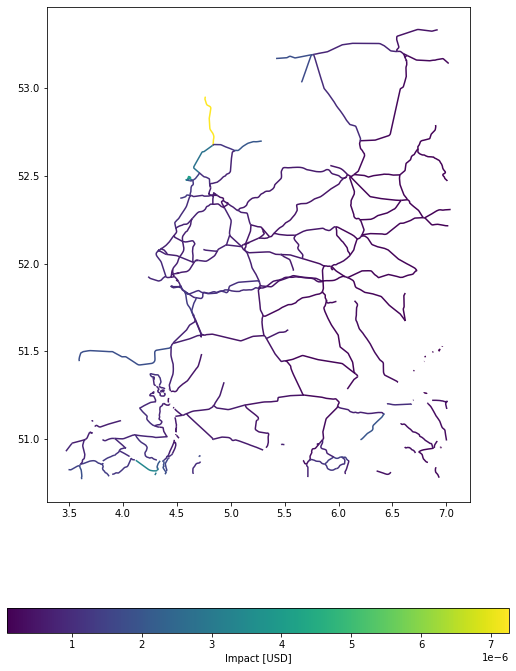

In [26]:
u_lp_handler.plot_eai_exp_geom(imp_m);

In [27]:
(imp_deg.eai_exp - imp_m.eai_exp) / imp_deg.eai_exp

array([ 0.00000000e+00, -1.27412784e-02,  4.59327820e-03,  9.14153768e-04,
        3.00468485e-02,  4.38299170e-03, -6.54369917e-04,  1.46831855e-03,
        1.23458121e-03,  0.00000000e+00, -2.79137276e-03, -1.03284897e-03,
        3.10957022e-03,  1.99920355e-03,  1.44488816e-03, -2.44525478e-04,
        5.81284709e-03,  2.12213836e-03, -7.80546180e-03,  2.63986086e-03,
        0.00000000e+00, -1.39206964e-02,  2.69350889e-03, -6.45572241e-03,
       -3.10087094e-03,  0.00000000e+00,  0.00000000e+00, -6.76896557e-03,
        0.00000000e+00, -4.15737280e-04, -7.87615458e-02,  0.00000000e+00,
        4.26623283e-03,  4.95411637e-03, -1.62941631e-03,  1.80679999e-02,
        3.00209187e-03,  6.42476571e-03, -2.19095101e-03, -9.74370439e-04,
       -2.02022084e-16,  2.18793198e-03, -1.25351098e-02,  0.00000000e+00,
        0.00000000e+00, -1.03878479e-03,  2.02022084e-16, -2.98766543e-03,
       -3.24997467e-03, -8.80850579e-03, -6.41392868e-06,  0.00000000e+00,
        2.64833296e-03, -

### <a id='Part2.3'></a> 2.3: Calculating line impacts - step by step

**Step 1:** As in the polygon example above, there are several methods to disaggregate line exposures into point exposures, of which several are shown here:

In [28]:
# 0.1° distance between points, average value disaggregation
exp_pnt = u_lp_handler.exp_geom_to_pnt(exp_nl_lines, res=0.1, to_meters=False, disagg='avg')
exp_pnt.gdf.head()

2022-02-24 18:40:45,579 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:653: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  line_lengths = gdf_lines.length
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:671: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_points = gdf_points.explode()


distance                                      geometry_orig  impf_WS  \
0 0   9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  1   9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
1 0  10397.965112  LINESTRING (6.17673 51.35530, 6.17577 51.35410...        1   
  1  10397.965112  LINESTRING (6.17673 51.35530, 6.17577 51.35410...        1   
  2  10397.965112  LINESTRING (6.17673 51.35530, 6.17577 51.35410...        1   

        value                  geometry   latitude  longitude  
0 0  0.500000  POINT (6.08850 50.87940)  50.879400   6.088500  
  1  0.500000  POINT (6.06079 50.80030)  50.800300   6.060790  
1 0  0.333333  POINT (6.17673 51.35530)  51.355300   6.176730  
  1  0.333333  POINT (6.12632 51.32440)  51.324399   6.126323  
  2  0.333333  POINT (6.08167 51.28460)  51.284600   6.081670

In [29]:
# 1000m distance between points, no value disaggregation
exp_pnt2 = u_lp_handler.exp_geom_to_pnt(exp_nl_lines, res=1000, to_meters=True, disagg=None)
exp_pnt2.gdf.head()

2022-02-24 18:40:48,779 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:671: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_points = gdf_points.explode()


distance                                      geometry_orig  impf_WS  \
0 0  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  1  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  2  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  3  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  4  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   

     value                  geometry   latitude  longitude  
0 0      1  POINT (6.08850 50.87940)  50.879400   6.088500  
  1      1  POINT (6.09416 50.87275)  50.872755   6.094165  
  2      1  POINT (6.09161 50.86410)  50.864105   6.091608  
  3      1  POINT (6.08744 50.85590)  50.855902   6.087435  
  4      1  POINT (6.08326 50.84770)  50.847699   6.083263

In [30]:
# 1000m distance between points, equal value disaggregation
exp_pnt3 = u_lp_handler.exp_geom_to_pnt(exp_nl_lines, res=1000, to_meters=True, disagg='avg')
exp_pnt3.gdf.head()

2022-02-24 18:40:49,211 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:671: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_points = gdf_points.explode()


distance                                      geometry_orig  impf_WS  \
0 0  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  1  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  2  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  3  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  4  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   

        value                  geometry   latitude  longitude  
0 0  0.090909  POINT (6.08850 50.87940)  50.879400   6.088500  
  1  0.090909  POINT (6.09416 50.87275)  50.872755   6.094165  
  2  0.090909  POINT (6.09161 50.86410)  50.864105   6.091608  
  3  0.090909  POINT (6.08744 50.85590)  50.855902   6.087435  
  4  0.090909  POINT (6.08326 50.84770)  50.847699   6.083263

In [31]:
# 1000m distance between points, disaggregation of value according to representative distance
exp_pnt4 = u_lp_handler.exp_geom_to_pnt(exp_nl_lines, res=1000, to_meters=True, disagg='surf')
exp_pnt4.gdf.head()

2022-02-24 18:40:51,114 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/evelynm/climada_python/climada/util/lines_polys_handler.py:671: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_points = gdf_points.explode()


distance                                      geometry_orig  impf_WS  \
0 0  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  1  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  2  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  3  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   
  4  9414.978692  LINESTRING (6.08850 50.87940, 6.08960 50.87850...        1   

     value                  geometry   latitude  longitude  
0 0   1000  POINT (6.08850 50.87940)  50.879400   6.088500  
  1   1000  POINT (6.09416 50.87275)  50.872755   6.094165  
  2   1000  POINT (6.09161 50.86410)  50.864105   6.091608  
  3   1000  POINT (6.08744 50.85590)  50.855902   6.087435  
  4   1000  POINT (6.08326 50.84770)  50.847699   6.083263

**Step 2 & 3:** The procedure is analogous to the example provided above for polygons.